In [91]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#### Preparing Data

In [92]:
train_data = pd.read_csv("/kaggle/input/imdb-dataset-sentiment-analysis-in-csv-format/Train.csv")
test_data = pd.read_csv("/kaggle/input/imdb-dataset-sentiment-analysis-in-csv-format/Test.csv")
validation_data = pd.read_csv("/kaggle/input/imdb-dataset-sentiment-analysis-in-csv-format/Valid.csv")

train_data.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


### Downsampling

We don't need much data to train the model, let's downsample it and train on a small subset.

In [93]:
# train_data = train_data.sample(1000, random_state=1).reset_index(drop=True)
# test_data = test_data.sample(200, random_state=1).reset_index(drop=True)
# validation_data = validation_data.sample(200, random_state=1).reset_index(drop=True)
# train_data.head()

,text,label
0,I was reviewing some old VHS tapes I have and ...,1
1,I never really knew who Robert Wuhl was before...,1
2,This movie grabbed me with the incredible open...,1
3,"Lame, cliched superhero action movie drivel. I...",0
4,Little did I know that when I signed up the th...,0


In [94]:
x_tr, y_tr = train_data['text'].values.astype(str), train_data['label'].values
x_val, y_val = validation_data['text'].values.astype(str), validation_data['label'].values
x_test,y_test = test_data['text'].values.astype(str) , test_data['label'].values
print(len(x_tr), len(y_tr))
print(len(x_val), len(y_val))
print(len(x_test), len(y_test))

1000 1000
200 200
200 200


In [95]:
#Tokenize the sentences
from string import punctuation
#convert all revies to lowercase
x_tr = np.char.lower(x_tr)
x_val = np.char.lower(x_val)
x_test = np.char.lower(x_test)

#remove punctuation
x_tr= [c for c in x_tr if c not in punctuation]
x_val = [c for c in x_val if c not in punctuation]
x_test = [c for c in x_test if c not in punctuation]

In [96]:
tokenizer = Tokenizer()

#preparing vocabulary
tokenizer.fit_on_texts(list(x_tr))

#converting text into integer sequences
x_tr_seq  = tokenizer.texts_to_sequences(x_tr) 
x_val_seq = tokenizer.texts_to_sequences(x_val)
x_test_seq = tokenizer.texts_to_sequences(x_test)


#padding to prepare sequences of same length
x_tr_pad  = pad_sequences(x_tr_seq, maxlen=1000)
x_val_pad = pad_sequences(x_val_seq, maxlen=1000)
x_test_pad = pad_sequences(x_test_seq,maxlen=1000)

We will need the original lengths of each sequence later:

In [97]:
#length of the reviews
seqlen_train = [len(x) for x in x_tr_seq]
seqlen_val = [len(x) for x in x_val_seq] 
seqlen_test = [len(x) for x in x_test_seq] 

In [98]:
# this might be an issue 
vocab=len(tokenizer.word_index) + 1 #+1 for padding
print(vocab)

18828


## Creating Tensors

#### Extract input and output tensors

In [99]:
# x = torch.tensor(train).to(torch.float64)

X_tr = torch.from_numpy(np.array(list(x_tr_pad)))
X_train = torch.tensor(X_tr).to(torch.int64)

y_train = torch.LongTensor(y_tr)
seqlen_train = torch.LongTensor(seqlen_train)
print(f"{X_train.size()},\n{y_train.size()}\n{seqlen_train.size() }\n")
print("tensor dimensions", X_train.dim)

X_v = torch.from_numpy(np.array(list(x_val_pad)))
X_val = torch.tensor(X_v).to(torch.torch.int64)

y_val = torch.LongTensor(y_val)
seqlen_val = torch.LongTensor(seqlen_val)
print(f"{X_val.size() },\n{y_val.size() }\n{seqlen_val.size() }\n")


X_t = torch.from_numpy(np.array(list(x_test_pad)))
X_test = torch.tensor(X_t).to(torch.torch.int64)

y_test = torch.LongTensor(y_test)
seqlen_test = torch.LongTensor(seqlen_test)
print(f"{X_test.size() },\n{y_test.size() }\n{seqlen_test.size() }")


torch.Size([1000, 1000]),
torch.Size([1000])
torch.Size([1000])

tensor dimensions <built-in method dim of Tensor object at 0x7f02d9233c30>
torch.Size([200, 1000]),
torch.Size([200])
torch.Size([200])

torch.Size([200, 1000]),
torch.Size([200])
torch.Size([200])


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


## The `LSTMClassifier` class

We now define our own LSTM sequence classifier model.

All PyTorch modules must subclass `nn.Module` (or one of its subclasses) and call `init` before any attribute assignment.

There two methods we have to implement:
- `__init__`: defines submodules. These constitute the nodes _computation graph_.
- `forward` implements the forward pass of the module. This is how we map the input to the output. The way we pass the input through the module implicitly builds a directed graph of the submodules named _computation graph_.

In [100]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size):
        super().__init__()
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.lstm = nn.LSTM(
            input_size=embedding_size,
            hidden_size=hidden_size,
            num_layers=1,
            bidirectional=True,
            batch_first=True,
        )
        self.dense = nn.Linear(hidden_size * 2, output_size)
        
    # the input signature of forward changes
    def forward(self, sequences, sequence_lens):
        embedded = self.embedding(sequences)
        
        # THIS IS THE MODIFIED PART
        # returns a PackedSequence object
        packed = nn.utils.rnn.pack_padded_sequence(
            embedded,
            sequence_lens.clamp(max=1000),
            enforce_sorted=False,
            batch_first=True)
        packed_outputs, (h, c) = self.lstm(packed)
        # extract LSTM outputs (not used here)
        lstm_outputs, lens = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        
        h = torch.cat((h[0], h[1]), dim=-1)
        output = self.dense(h)
        return output

## Instantiating the model

In [101]:
input_size = vocab
embedding_size = 30
hidden_size = 64
# number of labels i.e 2
output_size = train_data.label.nunique()

model = LSTMClassifier(input_size, embedding_size, hidden_size, output_size)
model

LSTMClassifier(
  (embedding): Embedding(18828, 30)
  (lstm): LSTM(30, 64, batch_first=True, bidirectional=True)
  (dense): Linear(in_features=128, out_features=2, bias=True)
)

## Batching

In [102]:
class BatchedIterator:
    def __init__(self, *tensors, batch_size):
        # all tensors must have the same first dimension
        assert len(set(len(tensor) for tensor in tensors)) == 1
        self.tensors = tensors
        self.batch_size = batch_size
    
    def iterate_once(self):
        num_data = len(self.tensors[0])
        for start in range(0, num_data, self.batch_size):
            end = start + self.batch_size
            yield tuple(tensor[start:end] for tensor in self.tensors)
            

In [103]:
train_iter = BatchedIterator(X_train, seqlen_train, y_train, batch_size=16)
#prints number of batches
for X, seqlens, y in train_iter.iterate_once():
    print(f"{X.size()  }, {seqlens.size()  }, {y.size() }")

torch.Size([16, 1000]), torch.Size([16]), torch.Size([16])
torch.Size([16, 1000]), torch.Size([16]), torch.Size([16])
torch.Size([16, 1000]), torch.Size([16]), torch.Size([16])
torch.Size([16, 1000]), torch.Size([16]), torch.Size([16])
torch.Size([16, 1000]), torch.Size([16]), torch.Size([16])
torch.Size([16, 1000]), torch.Size([16]), torch.Size([16])
torch.Size([16, 1000]), torch.Size([16]), torch.Size([16])
torch.Size([16, 1000]), torch.Size([16]), torch.Size([16])
torch.Size([16, 1000]), torch.Size([16]), torch.Size([16])
torch.Size([16, 1000]), torch.Size([16]), torch.Size([16])
torch.Size([16, 1000]), torch.Size([16]), torch.Size([16])
torch.Size([16, 1000]), torch.Size([16]), torch.Size([16])
torch.Size([16, 1000]), torch.Size([16]), torch.Size([16])
torch.Size([16, 1000]), torch.Size([16]), torch.Size([16])
torch.Size([16, 1000]), torch.Size([16]), torch.Size([16])
torch.Size([16, 1000]), torch.Size([16]), torch.Size([16])
torch.Size([16, 1000]), torch.Size([16]), torch.Size([16

 ## Loss function and optimizer

The **loss function** or **cost function** quantifies cost of the model output differing from the expected target values.

The optimizer adjusts the model's parameters in accordance with the loss.

In [104]:
from torch import optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

## Sanity check on Untrained models
Train and val accuracy should be really bad without training.

In [105]:
# # requires a large memory as we have a large vocab
# logits = model(X_train, seqlen_train)
# y = logits.argmax(axis=1)
# accuracy = torch.sum(torch.eq(y, y_train)) / y.size(0)
# print(f"Train accuracy: {accuracy:.1%}")

Train accuracy: 51.3%


In [106]:
# logits = model(X_val, seqlen_val)
# y = logits.argmax(axis=1)
# accuracy = torch.sum(torch.eq(y, y_val)) / y.size(0)
# print(f"Val accuracy: {accuracy:.1%}")

Val accuracy: 47.0%


## Training


We collect training statistics at the end of each epochs in `metrics`.

In [107]:
from collections import defaultdict
num_epochs = 30 
batch_size = 128

metrics = defaultdict(list)
train_iter = BatchedIterator(X_train, seqlen_train, y_train, batch_size=batch_size)

We train the model batch by batch and then evaluate it on the train and the dev data at the end of each epoch.
Since the dataset is small, we can evaluate it the whole data in one step without batching.

Note that the model should be set to **train** or **eval** mode accordingly. Stochastic steps such as dropout are disabled in **eval** mode.

In [108]:
patience = 2
patience_counter = 0
previous_loss = 100
previous_accuracy = 0
for epoch in range(num_epochs):
   
    model.train()
    # Training loop
    for X_batch, seqlen_batch, y_batch in train_iter.iterate_once():
        y_out = model(X_batch, seqlen_batch)
        loss = criterion(y_out, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        model.eval()  # or model.train(False)
        # Train and dev loss at the end of the epoch
        y_out = model(X_train, seqlen_train)
        train_loss = criterion(y_out, y_train).item()
        metrics['train_loss'].append(train_loss)
        labels = y_out.argmax(axis=1)
        train_accuracy = (torch.eq(y_train, labels).sum() / labels.size(0)).item()
        metrics['train_accuracy'].append(train_accuracy)

        y_out = model(X_val, seqlen_val)
        val_loss = criterion(y_out, y_val).item()
        metrics['val_loss'].append(val_loss)
        labels = y_out.argmax(axis=1)
        val_accuracy = (torch.eq(y_val, labels).sum() / labels.size(0)).item()
        metrics['val_accuracy'].append(val_accuracy)
        
        if val_accuracy <= previous_accuracy and val_loss <= previous_loss:
            patience_counter += 1
            
        previous_accuracy = val_accuracy
        previous_loss = val_loss
            
    
    print(f"{epoch} -- {train_loss:.3f} - {train_accuracy:.1%} - {val_loss:.3f} - {val_accuracy:.1%}")
    
#     if patience_counter == patience:
#             break

0 -- 0.693 - 52.6% - 0.693 - 49.0%
1 -- 0.692 - 52.7% - 0.695 - 49.0%
2 -- 0.691 - 52.8% - 0.695 - 49.0%
3 -- 0.690 - 52.8% - 0.693 - 49.0%
4 -- 0.690 - 52.7% - 0.693 - 49.0%
5 -- 0.689 - 52.7% - 0.694 - 49.0%
7 -- 0.688 - 52.8% - 0.693 - 49.0%
8 -- 0.686 - 53.0% - 0.693 - 49.0%
9 -- 0.685 - 53.2% - 0.693 - 49.0%
10 -- 0.683 - 53.2% - 0.693 - 49.0%
11 -- 0.680 - 53.5% - 0.695 - 49.0%
12 -- 0.676 - 54.1% - 0.698 - 48.5%
13 -- 0.671 - 54.3% - 0.703 - 48.0%
15 -- 0.662 - 54.9% - 0.713 - 47.5%
16 -- 0.656 - 55.2% - 0.724 - 47.5%
17 -- 0.658 - 55.0% - 0.724 - 47.5%
18 -- 0.655 - 55.3% - 0.719 - 48.0%
19 -- 0.649 - 55.5% - 0.735 - 47.0%
20 -- 0.649 - 55.4% - 0.722 - 48.0%
21 -- 0.644 - 55.6% - 0.762 - 47.0%
22 -- 0.642 - 55.6% - 0.743 - 47.0%
23 -- 0.641 - 55.7% - 0.751 - 46.5%
24 -- 0.639 - 55.8% - 0.781 - 46.5%
25 -- 0.638 - 55.8% - 0.774 - 46.5%
26 -- 0.639 - 55.8% - 0.751 - 47.0%
27 -- 0.638 - 55.8% - 0.778 - 46.5%
28 -- 0.637 - 55.8% - 0.809 - 46.0%
29 -- 0.637 - 55.8% - 0.824 - 46.0%


## Evaluation

### Training curves

<AxesSubplot:>

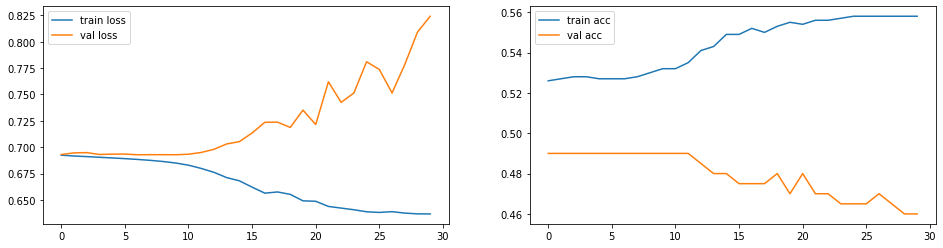

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(16, 4))

sns.lineplot(data=metrics['train_loss'], ax=ax[0], label='train loss')
sns.lineplot(data=metrics['val_loss'], ax=ax[0], label='val loss')

sns.lineplot(data=metrics['train_accuracy'], ax=ax[1], label='train acc')
sns.lineplot(data=metrics['val_accuracy'], ax=ax[1], label='val acc')

## Test accuracy

In [110]:
logits = model(X_test, seqlen_test)
test_prediction = logits.argmax(axis=1)
test_accuracy = torch.sum(torch.eq(test_prediction, y_test)) / y_test.size(0)
print(f"Test accuracy: {test_accuracy:.1%}")

Test accuracy: 51.5%
